In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)


In [6]:
import matplotlib.pyplot as plt
import matplotlib

# 日本語フォントの設定（例：Windowsなら 'Meiryo'、Macなら 'IPAexGothic' など）
plt.rcParams['font.family'] = 'Meiryo'  # WindowsならMeiryo、Yu Gothicなど
# plt.rcParams['font.family'] = 'IPAexGothic'  # Mac/Linuxならこちらもあり

# マイナス記号が文字化けしないように
matplotlib.rcParams['axes.unicode_minus'] = False


In [3]:
file_path = '../data/title.basics.tsv.gz'  # Notebookからの相対パス
df = pd.read_csv(file_path, sep='\t', na_values='\\N', low_memory=False)


In [3]:
# 映画だけに絞る
df = df[df['titleType'] == 'movie'].copy()

# 年代の整形
df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')
df = df.dropna(subset=['startYear'])
df['decade'] = (df['startYear'] // 10) * 10

# ジャンル分解（複数ジャンルがカンマ区切りで入っている）
df['genres'] = df['genres'].fillna('')
df_exploded = df.assign(genres=df['genres'].str.split(',')).explode('genres')
df_exploded = df_exploded[df_exploded['genres'] != '']


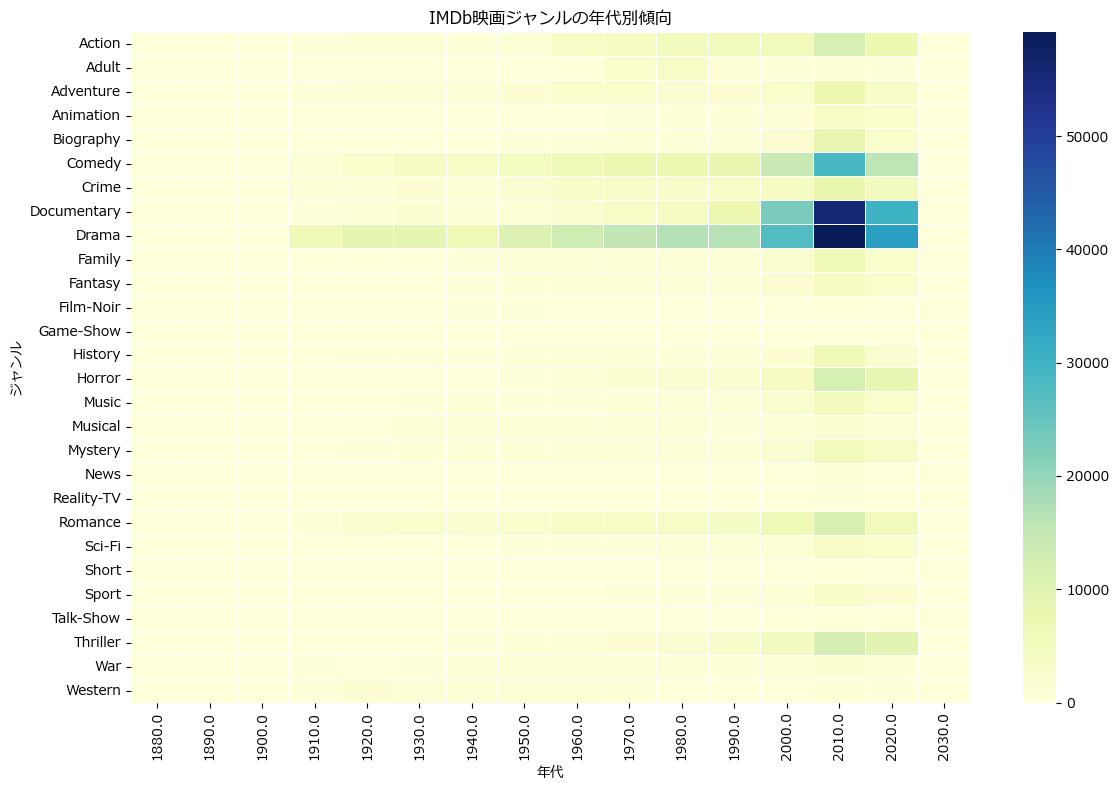

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(genre_decade.T, cmap='YlGnBu', linewidths=0.5)
plt.title("IMDb映画ジャンルの年代別傾向")
plt.xlabel("年代")
plt.ylabel("ジャンル")
plt.tight_layout()

# 保存処理を追加（.pngで保存）
plt.savefig('../figures/genre_trends_by_decade.png', dpi=300)

plt.show()


In [8]:
ratings = pd.read_csv('../data/title.ratings.tsv.gz', sep='\t')


In [9]:
df_filtered = df_exploded.merge(ratings, on='tconst', how='inner')


In [10]:
df_filtered = df_filtered[
    (df_filtered['averageRating'] >= 7.0) &
    (df_filtered['numVotes'] >= 1000)
]


In [11]:
genre_decade_highrated = df_filtered.groupby(['decade', 'genres']).size().unstack().fillna(0)


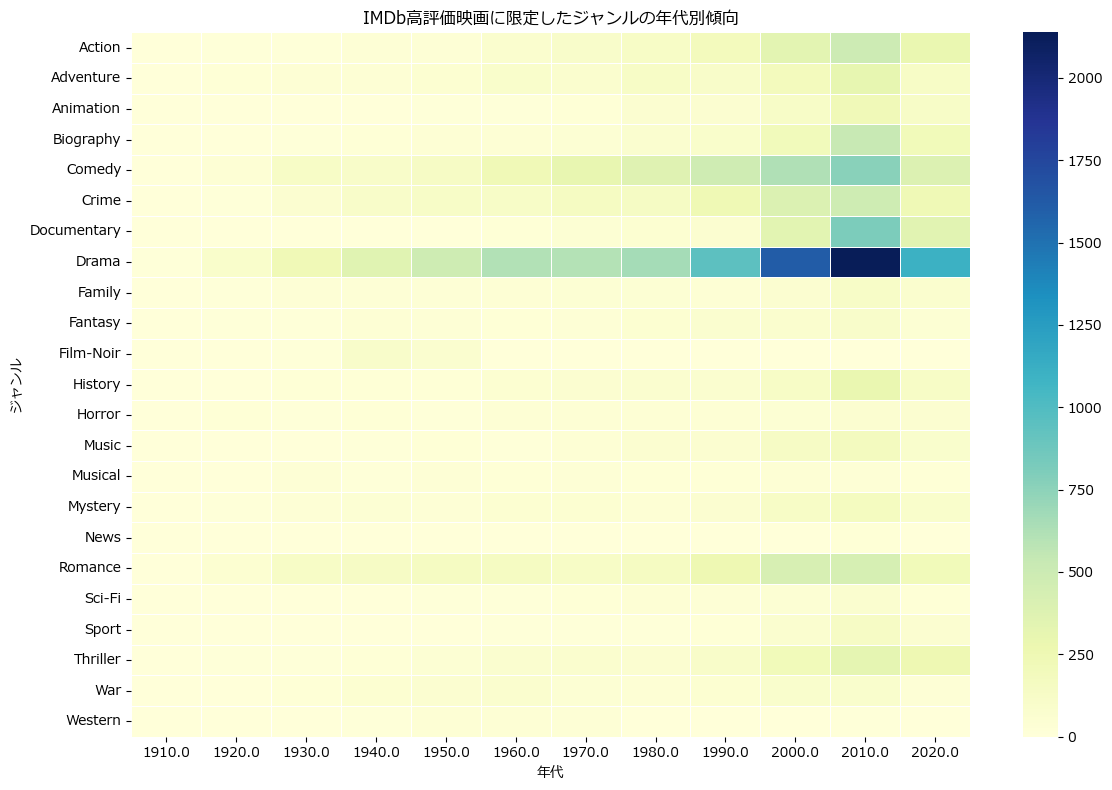

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(genre_decade_highrated.T, cmap='YlGnBu', linewidths=0.5)
plt.title("IMDb高評価映画に限定したジャンルの年代別傾向")
plt.xlabel("年代")
plt.ylabel("ジャンル")
plt.tight_layout()
plt.savefig('../figures/genre_trends_highrated.png', dpi=300)
plt.show()


In [13]:
# 行（各年代）ごとに合計を1にする（＝各ジャンルの相対的な割合）
genre_decade_normalized = genre_decade_highrated.div(genre_decade_highrated.sum(axis=1), axis=0)


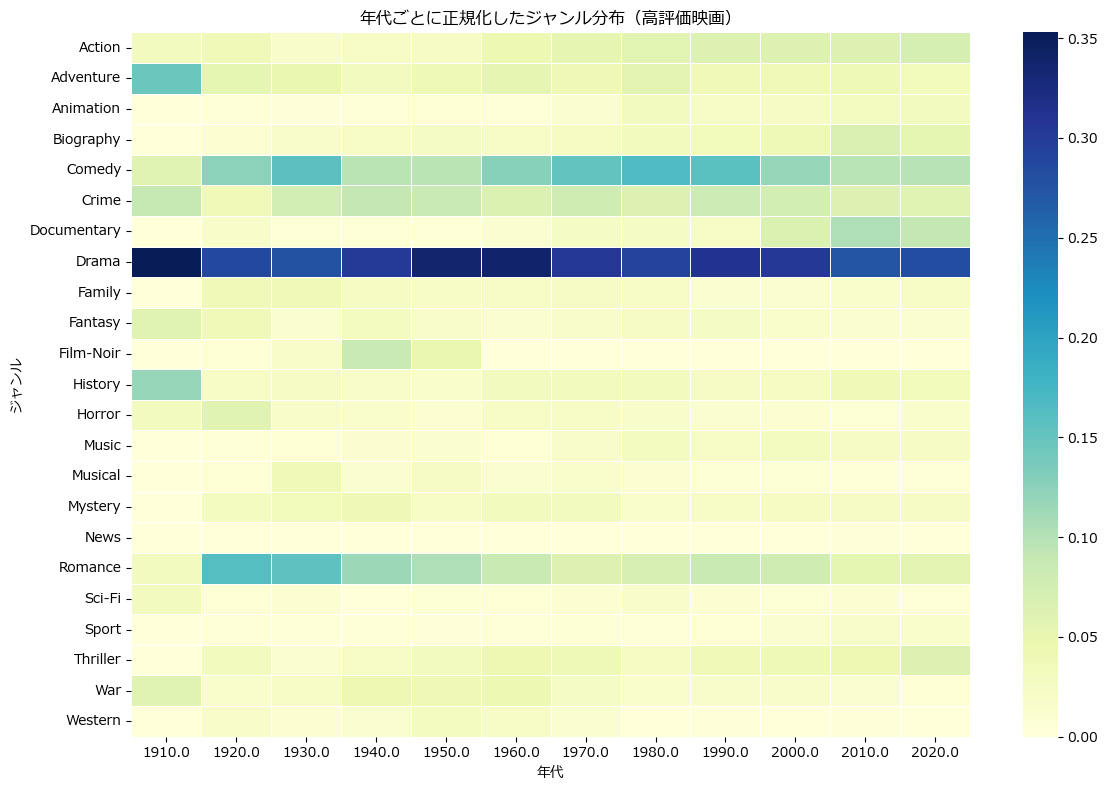

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(genre_decade_normalized.T, cmap='YlGnBu', linewidths=0.5)
plt.title("年代ごとに正規化したジャンル分布（高評価映画）")
plt.xlabel("年代")
plt.ylabel("ジャンル")
plt.tight_layout()
plt.savefig('../figures/genre_trends_highrated_normalized.png', dpi=300)
plt.show()


In [4]:
akas = pd.read_csv('../data/title.akas.tsv.gz', sep='\t', na_values='\\N', low_memory=False)


In [20]:
akas_japan = akas[akas['region'] == 'JP']


In [21]:
jp_tconsts = akas_japan['titleId'].unique()
df_japan = df[df['tconst'].isin(jp_tconsts)]


In [22]:
df_japan = df_japan.merge(ratings, on='tconst', how='inner')

# 例：高評価 + 投票数多いものに限定
df_japan_filtered = df_japan[
    (df_japan['averageRating'] >= 7.0) &
    (df_japan['numVotes'] >= 1000)
]


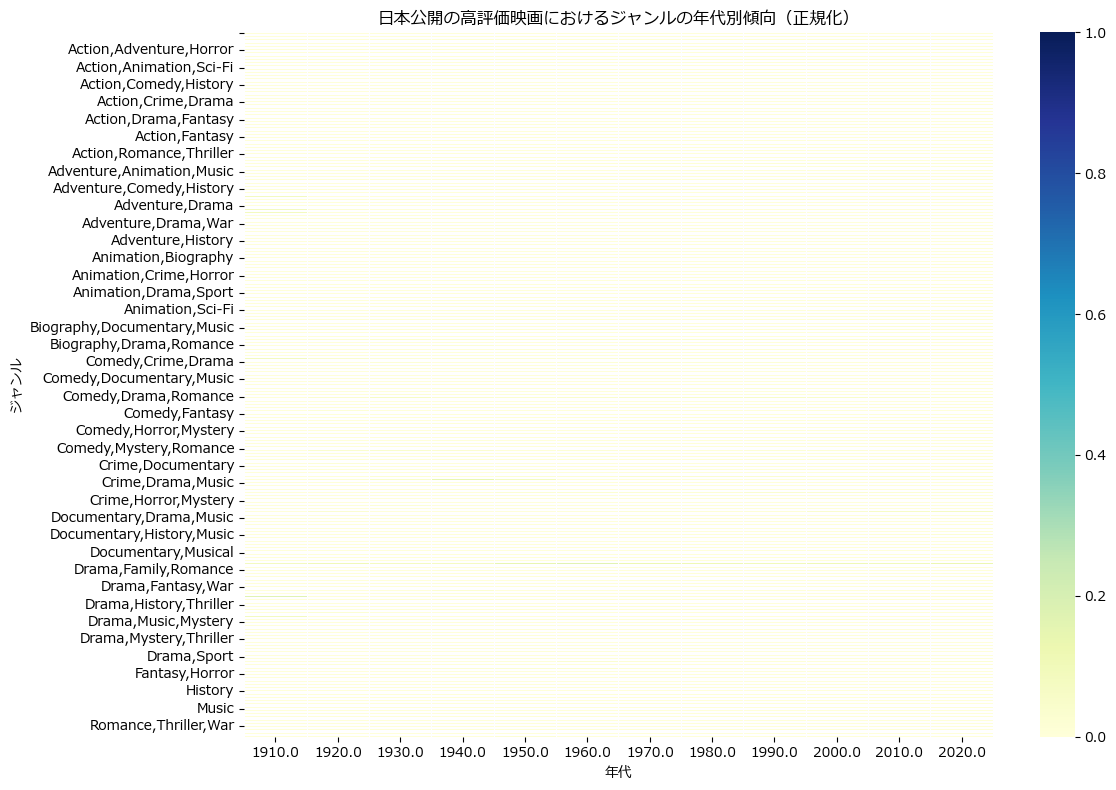

In [23]:
# クロス集計
genre_decade_japan = df_japan_filtered.groupby(['decade', 'genres']).size().unstack().fillna(0)

# 正規化（年代ごとの比率）
genre_decade_japan_norm = genre_decade_japan.div(genre_decade_japan.sum(axis=1), axis=0)

# 可視化
plt.figure(figsize=(12, 8))
sns.heatmap(genre_decade_japan_norm.T, cmap='YlGnBu', linewidths=0.5, vmin=0, vmax=1)
plt.title("日本公開の高評価映画におけるジャンルの年代別傾向（正規化）")
plt.xlabel("年代")
plt.ylabel("ジャンル")
plt.tight_layout()
plt.savefig('../figures/genre_trends_japan_highrated_normalized.png', dpi=300)
plt.show()


In [24]:
# 「,」を含まないジャンルだけを抽出（＝単一ジャンル）
df_japan_single = df_japan_filtered[df_japan_filtered['genres'].str.contains(',', na=False) == False]
genre_decade_single = df_japan_single.groupby(['decade', 'genres']).size().unstack().fillna(0)
genre_decade_single_norm = genre_decade_single.div(genre_decade_single.sum(axis=1), axis=0)


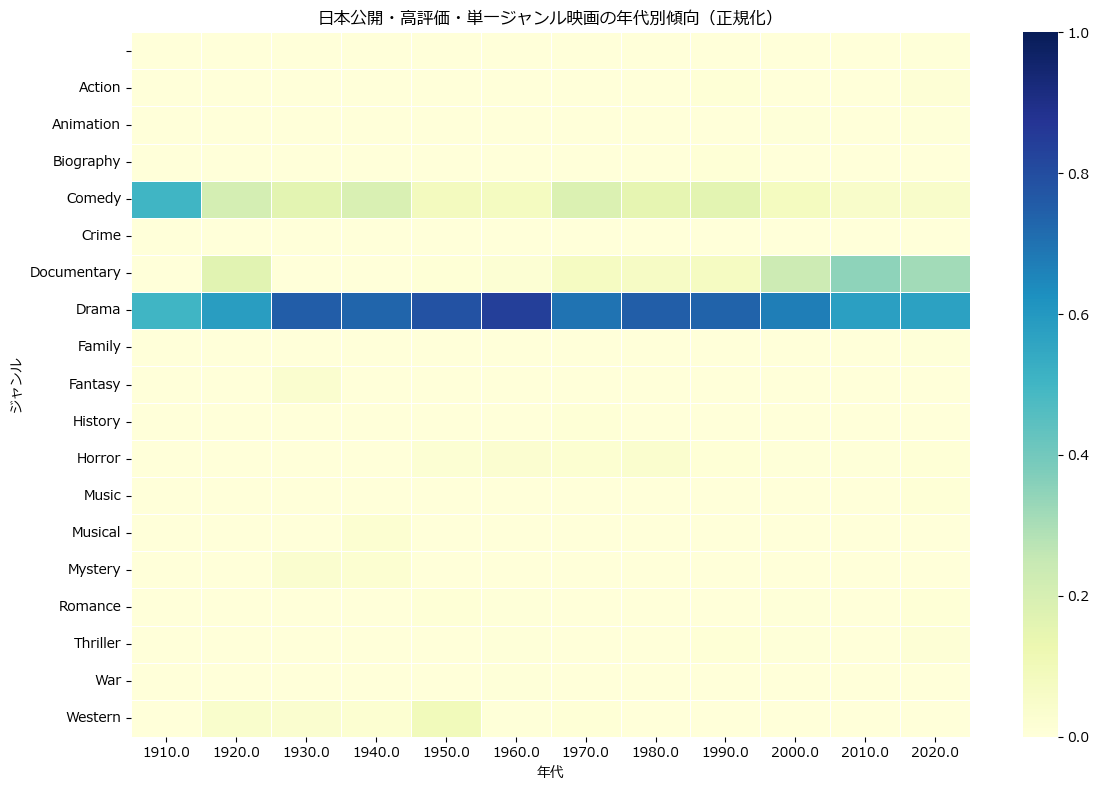

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    genre_decade_single_norm.T,
    cmap='YlGnBu',
    linewidths=0.5,
    vmin=0,
    vmax=1
)
plt.title("日本公開・高評価・単一ジャンル映画の年代別傾向（正規化）")
plt.xlabel("年代")
plt.ylabel("ジャンル")
plt.tight_layout()
plt.savefig('../figures/genre_trends_japan_highrated_single_genre.png', dpi=300)
plt.show()
